In [350]:
import time
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET

from skimage.transform import resize
from skimage import feature
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Traffic Sign Classification

## Load Dataset

##### xml.etree.ElementTree module implements a simple and efficient API for parsing and creating XML data

In [351]:
xml_file = 'annotations/road0.xml'
tree = ET.parse(xml_file)
root = tree.getroot()

for obj in root.findall('object'):
    classname = obj.find('name').text

    xmin = int(obj.find('bndbox/xmin').text)
    ymin = int(obj.find('bndbox/ymin').text)
    xmax = int(obj.find('bndbox/xmax').text)
    ymax = int(obj.find('bndbox/ymax').text)

    print(f'Classname: {classname}')
    print(f'Bounding box: {(xmin, ymin, xmax, ymax)}')

Classname: trafficlight
Bounding box: (98, 62, 208, 232)


In [352]:
annotations_dir = 'annotations'
im_dir = 'images'

im_lst = []
label_lst = []
for xml_file in os.listdir(annotations_dir):
    xml_filepath = os.path.join(annotations_dir, xml_file)
    tree = ET.parse(xml_filepath)
    root = tree.getroot()

    folder = root.find('folder').text
    im_filename = root.find('filename').text
    im_filepath = os.path.join(im_dir, im_filename)
    im = cv2.imread(im_filepath)

    for obj in root.findall('object'):
        classname = obj.find('name').text
        if classname == 'trafficlight':
            continue

        xmin = int(obj.find('bndbox/xmin').text)
        ymin = int(obj.find('bndbox/ymin').text)
        xmax = int(obj.find('bndbox/xmax').text)
        ymax = int(obj.find('bndbox/ymax').text)

        im_obj = im[ymin:ymax, xmin:xmax]
        im_lst.append(im_obj)
        label_lst.append(classname)

In [353]:
print('Number of objects: ', len(im_lst))
print('Class names: ', list(set(label_lst)))

Number of objects:  1074
Class names:  ['stop', 'crosswalk', 'speedlimit']


## Data Preprocessing

In [354]:
print('Image shape:\n', im_lst[1].shape)

Image shape:
 (41, 41, 3)


##### We can't currently feed the entire image (len(shape) == 3) as X to train the SVM model
##### We can only feed the flattened image (len(shape) == 1) as X to train the SVM model

In [355]:
flattened_im = im_lst[1].flatten()
print('Flattened image shape:\n', flattened_im.shape)

Flattened image shape:
 (5043,)


##### Flattening on raw images isn't good enough since the vector doesn't well represent the image
##### Use HoG (Histogram of Oriented Gradients) 


In [356]:
def preprocess(im):
    if len(im.shape) > 2:
        im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    im = im.astype(np.float32)

    # Resize all images to same size to ensure HOG vectors have same shape
    resized_im = resize(im, output_shape=(32, 32), anti_aliasing=True)

    hog_feature = feature.hog(
        resized_im,
        orientations=9,
        pixels_per_cell=(8, 8),
        cells_per_block=(2, 2),
        transform_sqrt=True,
        block_norm='L2',
        feature_vector=True
    )

    return hog_feature

In [357]:
im_features_lst = []
for im in im_lst:
    hog_feature = preprocess(im)
    im_features_lst.append(hog_feature)

im_features = np.array(im_features_lst)
print('X shape: ', im_features.shape)

X shape:  (1074, 324)


## Encode Label

In [358]:
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(label_lst)

In [359]:
label_encoder.classes_

array(['crosswalk', 'speedlimit', 'stop'], dtype='<U10')

In [360]:
print(encoded_labels)

[1 1 1 ... 1 1 1]


## Data Split

In [361]:
random_state = 215

X_train, X_val, y_train, y_val = train_test_split(
    im_features,
    encoded_labels,
    test_size=0.3,
    random_state=random_state,
    shuffle=True
)

## Normalization

In [362]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)


In [363]:
X_train

array([[ 0.6957291 ,  0.4888628 ,  0.5803794 , ..., -0.5654371 ,
        -0.5185006 , -0.2621483 ],
       [-0.47485468, -0.46013382,  0.92294735, ..., -0.45528477,
        -0.48389992, -0.59990895],
       [ 0.7169426 ,  2.0221536 ,  0.09895132, ..., -0.30432874,
        -0.5185006 , -0.4576377 ],
       ...,
       [ 0.40379956,  0.75342643,  0.33676296, ...,  1.7522858 ,
         1.4637086 ,  0.91330236],
       [-0.17584704, -1.4227092 , -1.5179651 , ...,  2.2113342 ,
         2.9121888 ,  1.772915  ],
       [-0.64950955,  1.069913  ,  0.9696684 , ..., -0.5654371 ,
        -0.4076002 , -0.6162246 ]], dtype=float32)

## Train SVM Model

In [364]:
clf = SVC(
    kernel='rbf',
    random_state=random_state,
    probability=True,
    C=0.5
)

clf.fit(X_train, y_train)

SVC(C=0.5, probability=True, random_state=215)

## Evaluation

In [365]:
y_pred = clf.predict(X_val)
score = accuracy_score(y_pred, y_val)

print('Evaluation results on val set')
print('Accuracy: ', score)

Evaluation results on val set
Accuracy:  0.9845201238390093


In [366]:
im = im_lst[1]
im = preprocess(im)

y_pred = clf.predict([im])[0]
print(f'Normal prediction: {y_pred}')

y_pred_prob = clf.predict_proba([im])
prediction = np.argmax(y_pred_prob)
y_pred_prob = [f'{p:.10f}' for p in y_pred_prob[0]]
print(f'Probability of each class: {y_pred_prob}')
print(f'Class with highest probability: {prediction}')

Normal prediction: 1
Probability of each class: ['0.0000000012', '0.9999620651', '0.0000379337']
Class with highest probability: 1


# Traffic Sign Localization

### Pyramid images -> Sliding Window (Multiple window sizes) -> Non-maximum Suppression

##### Sliding Window: A technique where fixed_size window (sub-rectangle) moves across an image to analyze a local region at a time

In [367]:
def sliding_window(im, window_sizes, stride, scale_factor):
    im_height, im_width = im.shape[:2]
    windows = []
    for window_size in window_sizes:
        window_width, window_height = window_size
        for ymin in range(0, im_height - window_height + 1, stride):
            for xmin in range(0, im_width - window_width + 1, stride):
                xmax = xmin + window_width
                ymax = ymin + window_height
                
                windows.append([xmin, ymin, xmax, ymax])

    return windows

##### In many situations, the objects of interest are often presented very small in the image. Therefore, directly applying a fixed-size window might not be effectively handle this

##### Pyramid image: A multi-scale representation of an input image where the image is processed at various scales (resolutions) to detect objects of different sizes

In [368]:
def pyramid(im, scale=0.8, min_size=(30, 30)):
    acc_scale = 1.0
    pyramid_ims = [(im, acc_scale)]

    i = 0
    while True:
        acc_scale *= scale
        # h, w = int(im.shape[:2] * acc_scale)
        h = int(im.shape[0] * acc_scale)
        w = int(im.shape[1] * acc_scale)
        if w < min_size[0] or h < min_size[1]:
            break

        im = cv2.resize(im, (w, h))
        pyramid_ims.append((im, acc_scale * (scale**i)))
        i += 1

    return pyramid_ims

##### Usually, raw output may have a lot of overlapped bounding boxes having the same confidence score.

##### Non-maximum Suppression (NMS): A technique used in object detection to prune multiple overlapped bounding boxes that refer to the same object

In [369]:
def calculate_iou(bbox, bboxes, area, areas):
    xmin = np.maximum(bbox[0], bboxes[:, 0])
    ymin = np.maximum(bbox[1], bboxes[:, 1])
    xmax = np.minimum(bbox[2], bboxes[:, 2])
    ymax = np.minimum(bbox[3], bboxes[:, 3])
    
    w = np.maximum(0, xmax - xmin + 1)
    h = np.maximum(0, ymax - ymin + 1)

    intersection = w * h

    return intersection / (area + areas - intersection)

In [370]:
def nms(bboxes, iou_thres):
    if not bboxes:
        return []
    scores = np.array([bbox[5] for bbox in bboxes])
    sorted_indices = np.argsort(scores)[::-1] # Descending

    xmin, ymin, xmax, ymax = np.array([[bbox[i] for bbox in bboxes] for i in range(4)])
    areas = (xmax - xmin + 1) * (ymax - ymin + 1)

    keep = []
    while sorted_indices.size > 0:
        idx = sorted_indices[0]
        keep.append(idx)

        iou = calculate_iou(
            (xmin[idx], ymin[idx], xmax[idx], ymax[idx]),
            np.array(
                [xmin[sorted_indices[1:]],
                 ymin[sorted_indices[1:]],
                 xmax[sorted_indices[1:]],
                 ymax[sorted_indices[1:]]]
            ).T,
            areas[idx],
            areas[sorted_indices[1:]]
        )
        
        idx_to_keep = np.where(iou <= iou_thres)[0]
        sorted_indices = sorted_indices[idx_to_keep + 1]
    return [bboxes[i] for i in keep]

In [371]:
def visualize_bbox(im, bboxes, label_encoder):
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

    for bbox in bboxes:
        xmin, ymin, xmax, ymax, pred_id, conf_score = bbox
        
        cv2.rectangle(im, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
        
        classname = label_encoder.inverse_transform([pred_id])[0]
        label = f'{classname} {conf_score:.2f}'

        (w, h), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 1)
        cv2.rectangle(im, (xmin, ymin - 20), (xmin + w, ymin), (0, 255, 0), -1)
        cv2.putText(im, label, (xmin, ymin - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 0), 1)

    plt.imshow(im)
    plt.axis('off')
    plt.show()

### Prediction

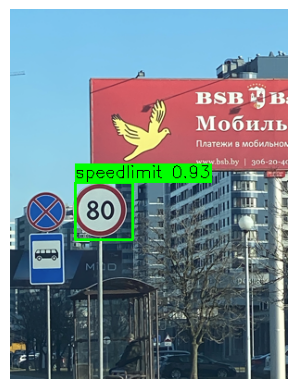

Time process:  2.969722032546997


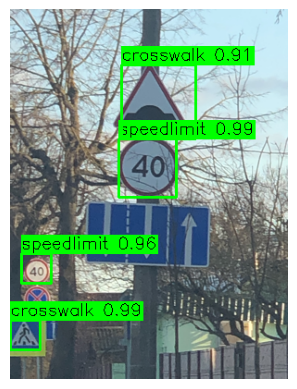

Time process:  2.8803389072418213


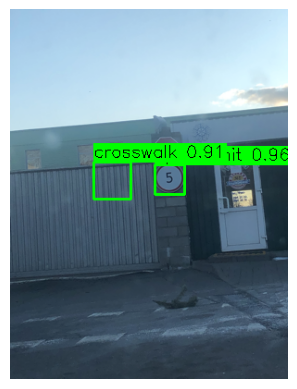

Time process:  2.8287370204925537


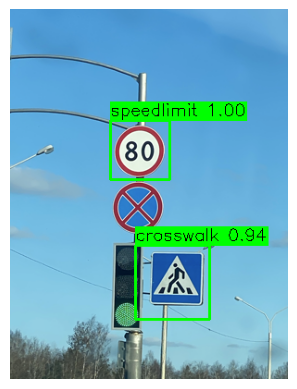

Time process:  2.7866599559783936


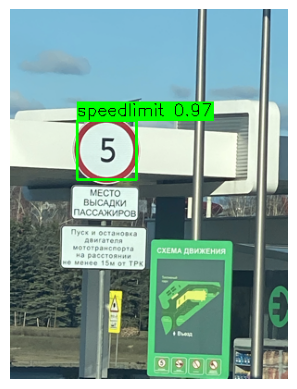

Time process:  2.914310932159424


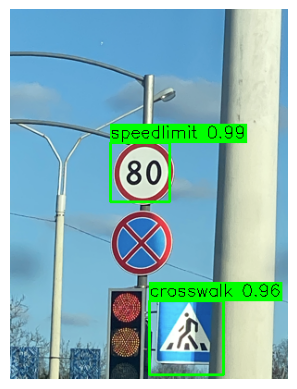

Time process:  2.8542299270629883


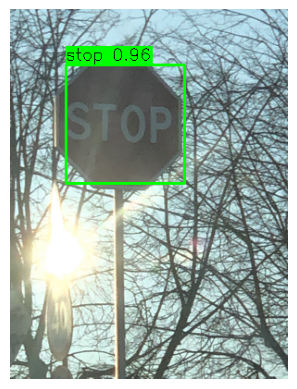

Time process:  2.8991830348968506


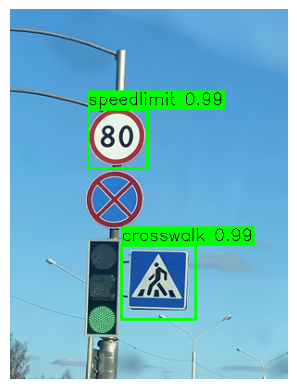

Time process:  2.9589271545410156


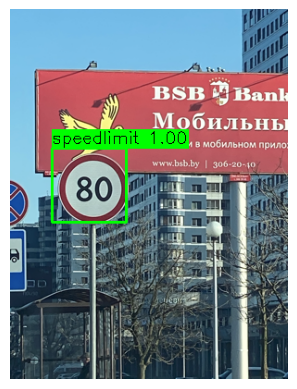

Time process:  2.8510332107543945


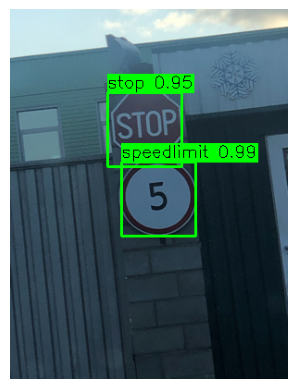

Time process:  2.9953479766845703


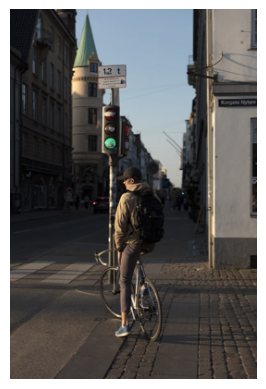

Time process:  2.47894287109375


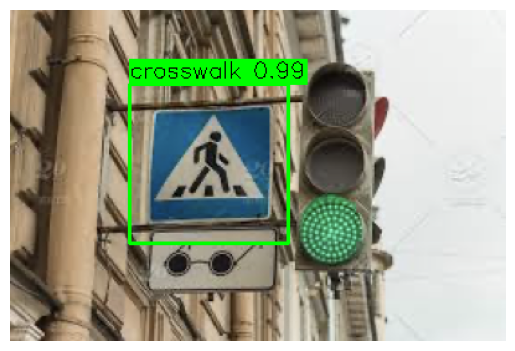

Time process:  2.5190296173095703


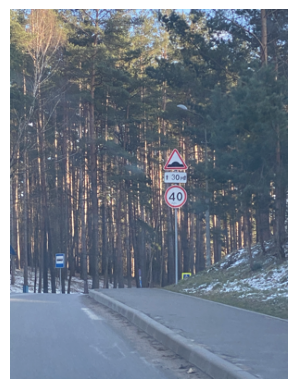

Time process:  2.9580421447753906


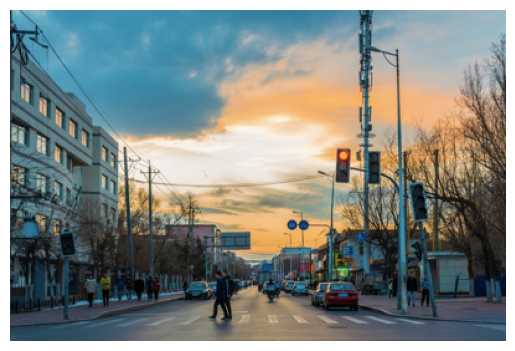

Time process:  2.570995330810547


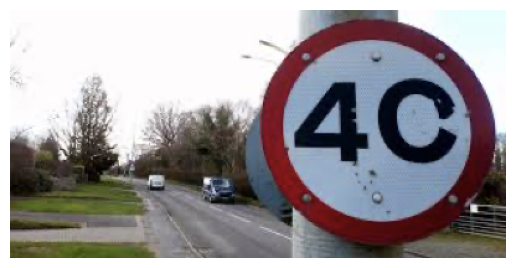

Time process:  1.7240891456604004


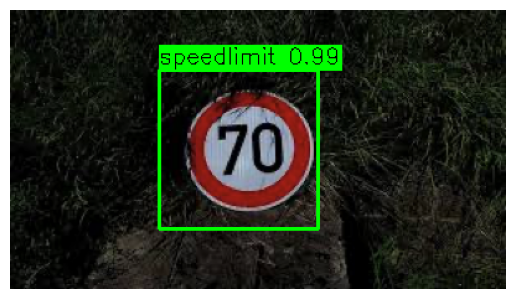

Time process:  2.0844550132751465


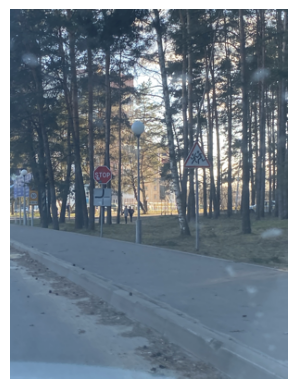

Time process:  2.9780869483947754


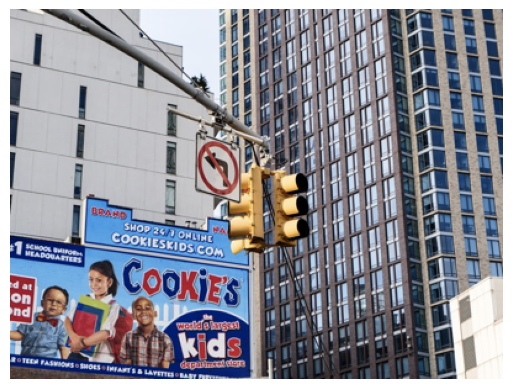

Time process:  3.0979700088500977


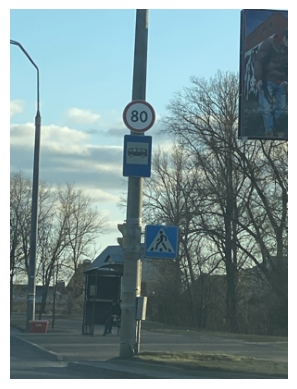

Time process:  3.0176517963409424


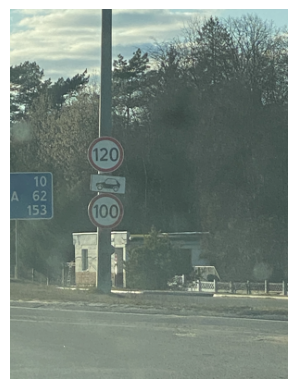

Time process:  3.0804178714752197


In [372]:
im_filename_lst = os.listdir(im_dir)[20:40]
conf_thres = 0.9
iou_thres = 0.05
stride = 12
window_sizes = [
    (32, 32),
    (64, 64),
    (128, 128)
]

for im_filename in im_filename_lst:
    start_time = time.time()
    im_filepath = os.path.join(im_dir, im_filename)

    bboxes = []
    im = cv2.imread(im_filepath)
    pyramid_ims = pyramid(im)
    
    for pyramid_im_info in pyramid_ims:
        pyramid_im, scale_factor = pyramid_im_info
        window_lst = sliding_window(
            pyramid_im,
            window_sizes=window_sizes,
            stride=stride,
            scale_factor=scale_factor
        )
        
        for window in window_lst:
            xmin, ymin, xmax, ymax = window

            obj_im = pyramid_im[ymin:ymax, xmin:xmax]
            preprocessed_im = preprocess(obj_im)
            normalized_im = scaler.transform([preprocessed_im])[0]
            pred = clf.predict_proba([normalized_im])[0]

            # Select bbox >= confidence threshold
            if np.all(pred < conf_thres):
                continue
            
            pred_id = np.argmax(pred)
            conf_score = pred[pred_id]

            # scale window back
            xmin = int(xmin / scale_factor)
            ymin = int(ymin / scale_factor)
            xmax = int(xmax / scale_factor)
            ymax = int(ymax / scale_factor)

            bboxes.append([xmin, ymin, xmax, ymax, pred_id, conf_score])

    bboxes = nms(bboxes, iou_thres)
    visualize_bbox(im, bboxes, label_encoder)
    print('Time process: ', time.time() - start_time)